In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.utils import resample
from scipy.stats import zscore

In [2]:
df = pd.read_csv("data/Chandler.csv")

In [3]:
df_clean = df[df["DROP"] == 0].copy()
df_clean["Anchortype_num"] = df_clean["Anchortype"].map({"round": 0, "precise": 1})

In [4]:
df.isna().sum()  # Check for missing values

DROP            0
Participant     0
Age             4
Gender          0
Year            0
Anchortype      0
magnitude       0
Condition       0
pen             8
Proteindrink    0
lebron          2
slidy           0
Cheese          0
Figurine        0
TV              0
beachhouse      0
number          0
Notes           0
dtype: int64

In [5]:
anchors = {
    "pen": {0: 4.000, 1: 3.998},
    "Proteindrink": {0: 10.0, 1: 9.8},
    "lebron": {0: 0.500, 1: 0.498},
    "slidy": {0: 40.00, 1: 39.75},
    "Cheese": {0: 5.00, 1: 4.85},
    "Figurine": {0: 50.00, 1: 49.00},
    "TV": {0: 5000.00, 1: 4998.00},
    "beachhouse": {0: 800000.00, 1: 799800.00},
    "number": {0: 10000, 1: 9989},
}


Compute Z-scores

In [6]:
for item in anchors:
    df_clean[item + "_dev"] = df_clean.apply(
        lambda row: row[item] - anchors[item][row["Anchortype_num"]], axis=1
    )
    df_clean["Z_" + item] = zscore(df_clean[item + "_dev"])

z_columns = [f"Z_{item}" for item in anchors]
df_clean["Zmean"] = df_clean[z_columns].mean(axis=1)


In [7]:
# ------------- Q4: Check Assumptions for ANOVA --------------------
anova_model = ols("Zmean ~ C(Anchortype) * C(magnitude)", data=df_clean).fit()
anova_results = sm.stats.anova_lm(anova_model, typ=2)


In [8]:
anova_results

,sum_sq,df,F,PR(>F)
C(Anchortype),1.452019,1.0,8.681717,3.885860e-03
C(magnitude),10.985844,1.0,65.685074,6.046046e-13
C(Anchortype):C(magnitude),0.005840,1.0,0.034920,8.520901e-01
Residual,19.401028,116.0,NaN,NaN


Anova assumption test

In [9]:
# Normality
shapiro_test = shapiro(anova_model.resid)

shapiro_test

ShapiroResult(statistic=np.float64(0.9642105317381298), pvalue=np.float64(0.0027983589630667734))

In [10]:
# Homogeneity of variances
levene_test = levene(
    df_clean[df_clean["Anchortype"] == "round"]["Zmean"],
    df_clean[df_clean["Anchortype"] == "precise"]["Zmean"]
)

In [11]:
levene_test

LeveneResult(statistic=np.float64(1.321714957549475), pvalue=np.float64(0.25260928384468473))

Eta squared

In [12]:
ss_total = sum(anova_results["sum_sq"])
anova_results["eta_sq"] = anova_results["sum_sq"] / ss_total

In [13]:
anova_results["eta_sq"]

C(Anchortype)                 0.045597
C(magnitude)                  0.344982
C(Anchortype):C(magnitude)    0.000183
Residual                      0.609238
Name: eta_sq, dtype: float64

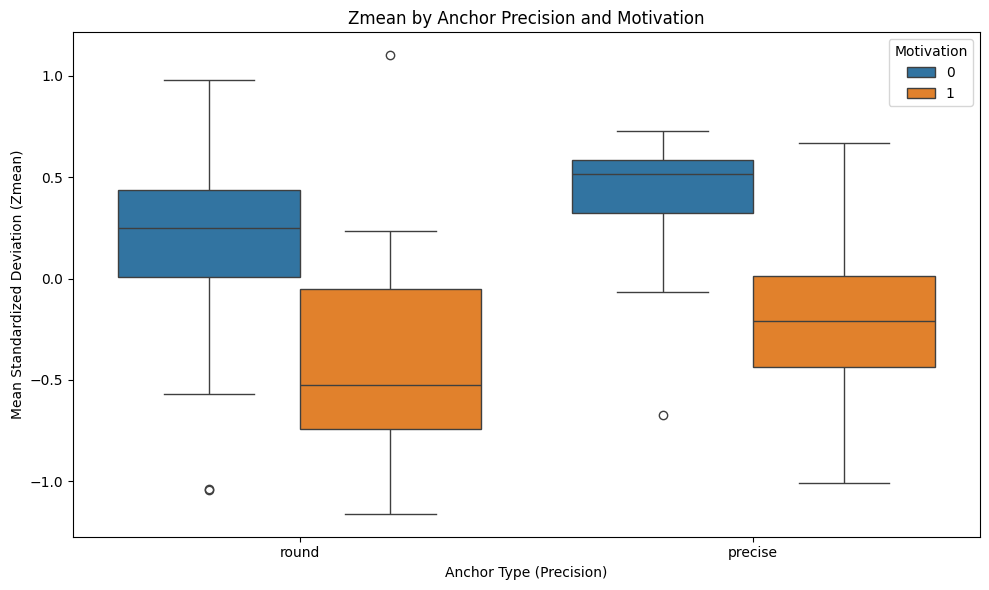

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x="Anchortype", y="Zmean", hue="magnitude")
plt.title("Zmean by Anchor Precision and Motivation")
plt.xlabel("Anchor Type (Precision)")
plt.ylabel("Mean Standardized Deviation (Zmean)")
plt.legend(title="Motivation")
plt.tight_layout()
plt.show()

In [15]:
print("ANOVA Results:\n", anova_results)
print("\nShapiro-Wilk Test (Normality):\n", shapiro_test)
print("\nLevene’s Test (Homogeneity of Variance):\n", levene_test)

ANOVA Results:
                                sum_sq     df          F        PR(>F)  \
C(Anchortype)                1.452019    1.0   8.681717  3.885860e-03   
C(magnitude)                10.985844    1.0  65.685074  6.046046e-13   
C(Anchortype):C(magnitude)   0.005840    1.0   0.034920  8.520901e-01   
Residual                    19.401028  116.0        NaN           NaN   

                              eta_sq  
C(Anchortype)               0.045597  
C(magnitude)                0.344982  
C(Anchortype):C(magnitude)  0.000183  
Residual                    0.609238  

Shapiro-Wilk Test (Normality):
 ShapiroResult(statistic=np.float64(0.9642105317381298), pvalue=np.float64(0.0027983589630667734))

Levene’s Test (Homogeneity of Variance):
 LeveneResult(statistic=np.float64(1.321714957549475), pvalue=np.float64(0.25260928384468473))
